# **Цель:** Разработать прототип модели, которая будет классифицировать комментарии пользователей о доставке на 50 различных классов

## **Задачи:**

1) Загрузить данные, сделать обзор
2) Выполнить предобработку данных: проверить данные на дубликаты, подобрать методы обработки пропусков (если они есть) и тд.
3) Подобрать способ векторизации комментариев пользователей
4) Разработать прототип модели
5) Получить предсказания лучшей модели на тестовой выборке и отправить решение заказчику

# Импорт библиотек

In [1]:
# Общие библиотеки
import os
import re
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Инструменты для обработки данных
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, 
    FunctionTransformer, 
    MultiLabelBinarizer
)
from sklearn.feature_extraction.text import TfidfVectorizer

# NLP-библиотеки
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from pymorphy2 import MorphAnalyzer

# Модели машинного обучения
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from xgboost import plot_tree

# Метрики и инструменты оценки
from sklearn.metrics import (
    accuracy_score, 
    classification_report
)
from sklearn.model_selection import (
    train_test_split, 
    KFold, 
    cross_val_score
)

# Оптимизация гиперпараметров
import optuna
from optuna.samplers import TPESampler

# Константа для воспроизводимости
RANDOM_STATE = 763

# Загрузка данных

In [2]:
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')

    print('Загрузка данных прошла успешно')

except:
    print('Не удалось загрузить данные')

Загрузка данных прошла успешно


# Обзор данных

In [3]:
def obzor(df):
    """
    Функция для анализа DataFrame. Выводит информацию о структуре,
    описательную статистику первых трёх столбцов, количество пропусков 
    и число дубликатов.
    """
    def separator(title=""):
        """Функция для добавления разделителя с заголовком."""
        print("\n" + "-" * 50)
        if title:
            print(f"{title:^50}")
            print("-" * 50)

    # Информация о DataFrame
    separator("Информация о DataFrame")
    display(df.info())

    # Описательная статистика первых трёх столбцов
    separator("Описательная статистика")
    display(df.iloc[:, :3].describe().T)

    # Количество пропусков в первых трёх столбцах
    separator("Пропуски")
    display(df.iloc[:, :3].isnull().sum())

    # Количество дубликатов
    separator("Количество дубликатов")
    print(f"Дубликаты: {df.duplicated().sum()}")

In [4]:
obzor(df_train)


--------------------------------------------------
              Информация о DataFrame              
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8708 entries, 0 to 8707
Data columns (total 54 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   index           8708 non-null   int64  
 1   assessment      8478 non-null   float64
 2   tags            8697 non-null   object 
 3   text            8708 non-null   object 
 4   trend_id_res0   8708 non-null   int64  
 5   trend_id_res1   8708 non-null   int64  
 6   trend_id_res2   8708 non-null   int64  
 7   trend_id_res3   8708 non-null   int64  
 8   trend_id_res4   8708 non-null   int64  
 9   trend_id_res5   8708 non-null   int64  
 10  trend_id_res6   8708 non-null   int64  
 11  trend_id_res7   8708 non-null   int64  
 12  trend_id_res8   8708 non-null   int64  
 13  trend_id_res9   8708 non-null   int64  
 14  trend_id_res10

None


--------------------------------------------------
             Описательная статистика              
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
index,8708.0,13438.49977,7847.950998,0.0,6685.25,13311.5,20302.5,27035.0
assessment,8478.0,4.06334,1.813434,0.0,3.00,5.0,5.0,6.0



--------------------------------------------------
                     Пропуски                     
--------------------------------------------------


index           0
assessment    230
tags           11
dtype: int64


--------------------------------------------------
              Количество дубликатов               
--------------------------------------------------
Дубликаты: 0


In [5]:
obzor(df_test)


--------------------------------------------------
              Информация о DataFrame              
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16999 entries, 0 to 16998
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       16999 non-null  int64  
 1   assessment  16533 non-null  float64
 2   tags        16967 non-null  object 
 3   text        16997 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 531.3+ KB


None


--------------------------------------------------
             Описательная статистика              
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
index,16999.0,13616.141773,7806.852237,1.0,6833.5,13726.0,20357.5,27039.0
assessment,16533.0,4.056554,1.827984,0.0,3.0,5.0,5.0,6.0



--------------------------------------------------
                     Пропуски                     
--------------------------------------------------


index           0
assessment    466
tags           32
dtype: int64


--------------------------------------------------
              Количество дубликатов               
--------------------------------------------------
Дубликаты: 0


In [6]:
df_train.sample(5)

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
7404,24783,2.0,"{PRICE,DELIVERY,SUPPORT,PRODUCTS_QUALITY}",Цены подняли слишком сильно,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6737,14134,5.0,{PROMOTIONS},Вы нас радуете вашей продукцией,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1828,2375,5.0,"{PRODUCTS_QUALITY,PRICE,PROMOTIONS}",Вам следует лучше следить за сроками годности ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
215,12300,5.0,{PROMOTIONS},"всегда выручаете,есть продукты,которые очень х...",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3360,2702,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PRICE,PROMOTIONS,...",Супер,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
df_test.sample(5)

,index,assessment,tags,text
5421,5338,5.0,"{DELIVERY,CATALOG_NAVIGATION,ASSORTMENT}","Классно , но могло быть и лучше"
15965,20385,5.0,"{DELIVERY,PRODUCTS_QUALITY,ASSORTMENT,PROMOTIONS}",Хороши
7990,22702,3.0,"{DELIVERY,PROMOTIONS,PRICE,PRODUCTS_QUALITY}",Не понятно долгая доставка
16124,16662,5.0,"{PRICE,PRODUCTS_QUALITY,ASSORTMENT,PROMOTIONS,...","Тщательней проверяйте фрукты и овощи, зачастую..."
584,23191,6.0,"{DELIVERY,SUPPORT}",Доставка подводит


In [8]:
with pd.option_context('display.max_colwidth', None):  
    print(df_train["text"].iloc[:10])

0                                       Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо
1                                                                                                                   Быстро
2                                                                                         Доставка постоянно задерживается
3                                                                                       Наценка и ассортимент расстраивают
4                                                                                                        Доставка просто 👍
5           Можно немного скинуть минимальную сумму заказа или оплачивать доставку ,если сумма меньше,как в Яндекс маркете
6    Некоторые продукты не очень хорошего качества, цены высокие слишком, в большинстве случаев курьеры доставляют вовремя
7                                                                                                Слишком часто опаздываете
8               

**Комментарий:**

- И в тренировочном, и в тестовом наборе данных наблюдается небольшое количество пропусков
- Стобец "index" следует удалить, так как он не несет никакой смысловой нагрузки для моделей
- Явных дубликатов не найдено в обоих наборах данных

# Описание тематик

In [9]:
trends_description = pd.read_csv("trends_description.csv")

In [10]:
# Создание словаря для замены названий столбцов
trend_mapping = dict(zip(
    [f"trend_id_res{i}" for i in trends_description['trend_id']],
    trends_description['trend']
))

In [11]:
with pd.option_context('display.max_colwidth', None):
    display(trends_description)

,trend_id,trend,explanation
0,0,Долгая доставка,- долго везёте\n- очень долго везёте\n- сюда относим замечания без конкретики\n
1,1,Доставка стала долгой,"- клиент делает акцент на то, что раньше мы доставляли быстрее"
2,2,Время доставки не соответствует заявленому,"- клиент акцентирует внимание, что SLA не соотвесвует реальному времени доставки (всегда или часто)\n- в комментарии указывать, если клиент акцентирует внимание, что мы НИКОГДА не выдерживаем заявленное время доставки"
3,3,Регулярные опоздания,"- клиент акцентриет внимание, что мы часто/каждый заказ привозим заказ с опозданием"
4,4,Не отследить реальное время доставки,"- клиент говорит о том, что невозможно понять, когда приедет заказ\n- нет реального времени доставки\n- клиент задает вопрос ""где заказ""/""долго ли ждать"""
5,5,Курьер на карте,"- если клиент упоминает отображение курьера на карте (даже если мы предполагаем, что он просто хочет понимать, когда будет заказ)"
6,6,Нет доставки по адресу,"клиент жалутеся, что нет доставки по адресу"
7,7,Не предупреждаем об удалении товара,- не предупреждаем об удалении товара\n- не предлагаем замену товара
8,8,Высокая минимальная сумма заказа,клиент жалуется на размер минимальной суммы заказа
9,9,Сумма заказа меняется во время набора корзины,- сумма заказа меняется во время набора корзины \n- приходится несколько раз докладывать товары до мин суммы


# Предобработка данных

## Удаление столбца "index"

In [12]:
df_train.drop(columns=['index'], inplace=True)
df_test.drop(columns=['index'], inplace=True)

In [13]:
df_train.sample(1)

,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
1381,5.0,"{ASSORTMENT,PRICE,PROMOTIONS,PAYMENT,DELIVERY,...",Очень нравиться,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_test.sample(1)

,assessment,tags,text
13481,5.0,"{ASSORTMENT,PRICE,SUPPORT,PROMOTIONS}","в целом, очень хорошо и удобно. но, в последне..."


## Обработка пропусков

In [15]:
df_train.dropna(inplace=True)
df_train.reset_index(drop=True, inplace=True)

df_test['assessment'] = df_test['assessment'].fillna(df_train['assessment'].median())

df_test['tags'] = df_test['tags'].fillna('Unknown')

df_test['text'] = df_test['text'].fillna('Неизвестно')

In [16]:
df_train.iloc[:, :3].isnull().sum()

assessment    0
tags          0
text          0
dtype: int64

In [17]:
df_test.iloc[:, :3].isnull().sum()

assessment    0
tags          0
text          0
dtype: int64

## Изменение типа данных в столбце "assessment"

In [18]:
df_train['assessment'] = df_train['assessment'].astype('int64')
df_test['assessment'] = df_test['assessment'].astype('int64')

## Обрабтка столбца text

In [19]:
# Загрузка необходимых ресурсов
nltk.download('stopwords')
nltk.download('punkt_tab')

# Инициализация лемматизатора и стоп-слов
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [20]:
def preprocess_text_column(df, text_column, cache_path="preprocessed_text.pkl"):
    """
    Обрабатывает текстовый столбец в DataFrame:
    - Удаляет спецсимволы.
    - Выполняет токенизацию.
    - Удаляет стоп-слова.
    - Применяет лемматизацию.
    - Сохраняет результаты обработки в файл для повторного использования.
    
    Аргументы:
        df (pd.DataFrame): Исходный DataFrame.
        text_column (str): Название текстового столбца.
        cache_path (str): Путь для сохранения/загрузки обработанного столбца.
    
    Возвращает:
        pd.DataFrame: DataFrame с обработанным текстовым столбцом.
    """
    if os.path.exists(cache_path):
        # Загружаем обработанный столбец из кеша
        print(f"Загружаем обработанные данные из {cache_path}...")
        processed_text = joblib.load(cache_path)
        df[text_column] = processed_text
        return df

    def preprocess_text(text):
        # Удаление спецсимволов и приведение к нижнему регистру
        text = re.sub(r'[^а-яА-ЯёЁ\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip().lower()
        
        # Токенизация
        tokens = word_tokenize(text)
        
        # Удаление стоп-слов и лемматизация
        lemmatized = [morph.parse(word)[0].normal_form for word in tokens if word not in stop_words]
        
        # Соединяем обработанные токены обратно в строку
        return ' '.join(lemmatized)

    # Применение обработки к текстовому столбцу
    print("Обработка текстового столбца...")
    df[text_column] = df[text_column].apply(preprocess_text)

    # Сохраняем обработанный столбец в файл
    print(f"Сохраняем обработанные данные в {cache_path}...")
    joblib.dump(df[text_column], cache_path)
    
    return df

In [21]:
df_train = preprocess_text_column(df_train, text_column="text", cache_path="train_text_preprocessed.pkl")

Загружаем обработанные данные из train_text_preprocessed.pkl...


In [22]:
df_test = preprocess_text_column(df_test, text_column="text", cache_path="test_text_preprocessed.pkl")

Загружаем обработанные данные из test_text_preprocessed.pkl...


In [23]:
with pd.option_context('display.max_colwidth', None):  
    print(df_train["text"].iloc[80:90])

80    ваш приложение сначала думать это хуавеять старый вытягивать ловить фриз глюк непрогоуз картинка самсунг это печаль
81                                                                                                        долгий доставка
82                                                                            крутоно доставка стать постоянно опаздывать
83                                                                             доставка быстраять цена вкусняшка огорчать
84                                                                                      стать жить гораздо лёгкий спасибо
85                                                                                                              прекрасно
86                                                                 оплатить наличные хороший сервис ещё нету многий товар
87                                                         писать доставка минутный сам дело писаться курьер минута ждать
88                      

In [24]:
with pd.option_context('display.max_colwidth', None):  
    print(df_test["text"].iloc[40:49])

40                                                                                  очень медленно работать
41                                                          невозможно дозвониться поддержка понятно курьер
42                                                               часто сталкиваться плохой качество продукт
43                                                                                                дорговато
44                                                                   быстрый доставка горячий едыэтый супер
45                                                              слишком долгий доставка очень удобный поиск
46                                            очень актуально человек ограниченный передвижение благодарить
47    ассортимент продукт маленький цена завысить немного домашний еда вкусный заказывать салат борщ поесть
48                                                                                              очень круто
Name: text, dtype: object


## Создание новых признаков на основе столбца text

In [25]:
def feature_eng(df):
    df['text_length'] = df['text'].map(len)
    df['unique_words'] = df['text'].map(lambda x: len(set(x.split())))

    return df

In [26]:
df_train = feature_eng(df_train)

In [27]:
df_test = feature_eng(df_test)

In [28]:
df_train.sample(5)

,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,...,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,text_length,unique_words
1004,4,"{DELIVERY,SUPPORT}",частенько привозить заказ полчаса,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,33,4
5245,6,"{PRODUCTS_QUALITY,PROMOTIONS,PRICE}",хороший быстрый очень дорогой свежий идти скид...,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,197,25
1482,5,"{CATALOG_NAVIGATION,PROMOTIONS}",супер,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5,1
4850,5,"{SUPPORT,DELIVERY}",супер очень часто бывать курьер задерживаться ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,195,24
6225,5,"{PROMOTIONS,ASSORTMENT,PRODUCTS_QUALITY}",хотеться выбор готовый еда разнообразный,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,40,5


In [29]:
df_test.sample(5)

,assessment,tags,text,text_length,unique_words
5720,5,"{DELIVERY,SUPPORT}",указывать точный время доставка предупреждать ...,65,8
4870,5,{DELIVERY},стоить заявлять минута доставка минута занять ...,89,11
2013,0,"{PROMOTIONS,PRICE}",класс,5,1
3623,0,"{PAYMENT,DELIVERY}",оплатить заказ ждать минута деньга вернуть отм...,115,15
5870,5,"{ASSORTMENT,PRODUCTS_QUALITY,PRICE,PROMOTIONS}",небольшой ассортимент,21,2


## Обработка столбца "tags" 

In [30]:
df_train['tags'].value_counts(ascending=True)

tags
{PAYMENT,SUPPORT,PRICE,PROMOTIONS}                                                               1
{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALOG_NAVIGATION,PRICE}                                1
{PROMOTIONS,PRICE,PAYMENT,SUPPORT}                                                               1
{SUPPORT,DELIVERY,PAYMENT,CATALOG_NAVIGATION,PROMOTIONS,PRICE,ASSORTMENT,PRODUCTS_QUALITY}       1
{SUPPORT,PRICE,PRODUCTS_QUALITY,ASSORTMENT}                                                      1
                                                                                              ... 
{DELIVERY,SUPPORT}                                                                             292
{ASSORTMENT,PRICE,PROMOTIONS}                                                                  342
{ASSORTMENT,PROMOTIONS}                                                                        419
{PROMOTIONS}                                                                                   447
{DELI

In [31]:
df_train['tags'] = [tags.strip('{}').replace(' ', '').split(',') for tags in df_train['tags']]

In [32]:
df_test['tags'] = [tags.strip('{}').replace(' ', '').split(',') for tags in df_test['tags']]

In [33]:
df_train['tags']

0                      [ASSORTMENT, PROMOTIONS, DELIVERY]
1         [ASSORTMENT, PRICE, PRODUCTS_QUALITY, DELIVERY]
2       [DELIVERY, PROMOTIONS, PRICE, ASSORTMENT, SUPP...
3                         [PRICE, PROMOTIONS, ASSORTMENT]
4       [ASSORTMENT, PRODUCTS_QUALITY, PROMOTIONS, CAT...
                              ...                        
8462                      [ASSORTMENT, PRICE, PROMOTIONS]
8463                                           [DELIVERY]
8464       [PROMOTIONS, PRICE, SUPPORT, PRODUCTS_QUALITY]
8465                         [DELIVERY, PRODUCTS_QUALITY]
8466    [ASSORTMENT, PRICE, PROMOTIONS, DELIVERY, CATA...
Name: tags, Length: 8467, dtype: object

In [34]:
df_test['tags']

0                                             [PROMOTIONS]
1                                               [DELIVERY]
2                                 [ASSORTMENT, PROMOTIONS]
3                            [PRICE, DELIVERY, ASSORTMENT]
4        [ASSORTMENT, PRODUCTS_QUALITY, PRICE, PROMOTIO...
                               ...                        
16994                      [PAYMENT, ASSORTMENT, DELIVERY]
16995    [PRODUCTS_QUALITY, ASSORTMENT, PAYMENT, DELIVERY]
16996    [ASSORTMENT, PRODUCTS_QUALITY, PRICE, PROMOTIO...
16997                [PRODUCTS_QUALITY, SUPPORT, DELIVERY]
16998            [ASSORTMENT, PRICE, PROMOTIONS, DELIVERY]
Name: tags, Length: 16999, dtype: object

In [35]:
# Инициализация MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Обучение и трансформация на обучающем наборе
df_train_tags_encoded = mlb.fit_transform(df_train['tags'])

# Преобразуем закодированные метки в DataFrame
df_train_tags_encoded = pd.DataFrame(
    df_train_tags_encoded,
    columns=mlb.classes_,
    index=df_train.index
)

# Аналогично трансформируем тестовый набор
df_test_tags_encoded = mlb.transform(df_test['tags'])
df_test_tags_encoded = pd.DataFrame(
    df_test_tags_encoded,
    columns=mlb.classes_,
    index=df_test.index
)

# Соединяем обратно закодированные метки с исходными данными
df_train = pd.concat([df_train.drop(columns=['tags']), df_train_tags_encoded], axis=1)
df_test = pd.concat([df_test.drop(columns=['tags']), df_test_tags_encoded], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['Unknown'] will be ignored
  warnings.warn(


In [36]:
df_train

,assessment,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,...,text_length,unique_words,ASSORTMENT,CATALOG_NAVIGATION,DELIVERY,PAYMENT,PRICE,PRODUCTS_QUALITY,PROMOTIONS,SUPPORT
0,6,маленький выбор товар хотеться ассортимент вроде,0,0,0,0,0,0,0,0,...,48,6,1,0,1,0,0,0,1,0
1,4,быстро,0,0,0,0,0,0,0,0,...,6,1,1,0,1,0,1,1,0,0
2,6,доставка постоянно задерживаться,0,0,0,1,0,0,0,0,...,32,3,1,0,1,0,1,0,1,1
3,6,наценка ассортимент расстраивать,0,0,0,0,0,0,0,0,...,32,3,1,0,0,0,1,0,1,0
4,5,доставка просто,0,0,0,0,0,0,0,0,...,15,2,1,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462,5,неплохо целое,0,0,0,0,0,0,0,0,...,13,2,1,0,0,0,1,0,1,0
8463,6,пойти,0,0,0,0,0,0,0,0,...,5,1,0,0,1,0,0,0,0,0
8464,6,давать абузить поддержка возвращать деньга исп...,0,0,0,0,0,0,0,0,...,57,7,0,0,0,0,1,1,1,1
8465,2,очень плохой доставка первый очередь постоянны...,1,0,0,0,0,0,0,0,...,83,11,0,0,1,0,0,1,0,0


In [37]:
df_test

,assessment,text,text_length,unique_words,ASSORTMENT,CATALOG_NAVIGATION,DELIVERY,PAYMENT,PRICE,PRODUCTS_QUALITY,PROMOTIONS,SUPPORT
0,5,крутой компания удобный приложение,34,4,0,0,0,0,0,0,1,0
1,3,последний время думать плохо срок доставка дав...,77,12,0,0,1,0,0,0,0,0
2,5,супер,5,1,1,0,0,0,0,0,1,0
3,2,цена намного выше магазинный радовать акция,43,6,1,0,1,0,1,0,0,0
4,5,отлично,7,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
16994,6,сумма заказ высокий зачастую играть главный ро...,76,11,1,0,1,1,0,0,0,0
16995,5,всё отлично цена мочь ниже,26,5,1,0,1,1,0,1,0,0
16996,5,мда,3,1,1,1,1,1,1,1,1,1
16997,3,часто заказывать молочный продукция приходить ...,72,9,0,0,1,0,0,1,0,1


# Вывод по предобработке данных

1. **Удаление ненужных данных:**
   - Из тренировочного и тестового наборов удален столбец `index`, так как он не несет полезной информации для моделей.
   - Это помогает уменьшить размерность данных и исключить лишние шумы.

2. **Обработка пропусков:**
   - Пропуски в тренировочных данных удаляются полностью, что может сократить размер данных, но позволяет работать с более чистыми данными.
   - В тестовом наборе пропущенные значения заполняются:
     - Для числового столбца `assessment` используется медиана.
     - Для категорийного столбца `tags` добавляется категория `"Unknown"`.
     - Для текстового столбца `text` добавляется значение `"Неизвестно"`.
   - Такой подход помогает сохранить целостность данных и обеспечить корректную работу алгоритмов.

3. **Приведение типов:**
   - Столбец `assessment` приводится к целочисленному типу (`int64`), что гарантирует корректное использование числовых данных в дальнейшем.

4. **Обработка текста:**
   - Текстовые данные очищаются от спецсимволов, приводятся к нижнему регистру и токенизируются.
   - Удаляются стоп-слова, и для каждого слова выполняется лемматизация, что помогает привести слова к их базовым формам.
   - Результаты обработки текста кэшируются, что ускоряет последующую работу с данными.
   - Этот шаг уменьшает объем текста, делая его более стандартизированным для машинного обучения.

5. **Генерация новых признаков:**
   - Для текстовых данных создаются два новых признака:
     - Длина текста (`text_length`), которая отражает количество символов.
     - Количество уникальных слов (`unique_words`), показывающее разнообразие словаря в тексте.
   - Эти признаки предоставляют дополнительные полезные характеристики для моделей.

6. **Обработка мультикатегорийных меток:**
   - Столбец `tags` преобразуется из строкового формата в списки категорий.
   - Для кодирования мультикатегорийных меток используется `MultiLabelBinarizer`, который преобразует их в бинарный формат, пригодный для машинного обучения.
   - Это гарантирует, что тренировочные и тестовые данные имеют одинаковую структуру меток.

# Анализ дисбаланса классов

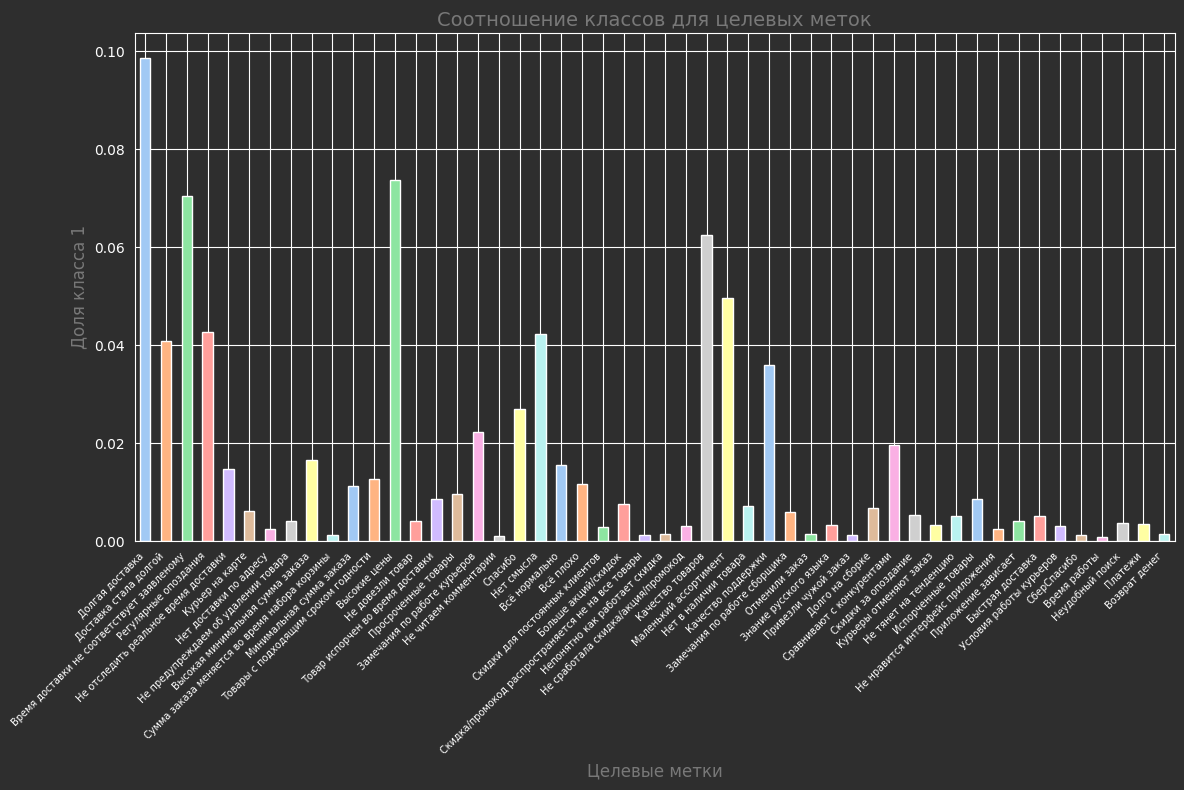

In [38]:
# Подсчёт доли класса 1 для столбцов trend_id_res0 - trend_id_res49
target_columns = [col for col in df_train.columns if col.startswith('trend_id_res')]
class_distribution = df_train[target_columns].sum() / len(df_train)

# Заменяем названия столбцов на более информативные
class_distribution.index = class_distribution.index.map(trend_mapping)

# Построение графика
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('#2e2e2e')

# Построение столбчатой диаграммы
class_distribution.plot(kind='bar', ax=ax, color=sns.color_palette("pastel"))

# Настройка дизайна
ax.set_title('Соотношение классов для целевых меток', color='#787878', fontsize=14)
ax.set_xlabel('Целевые метки', color='#787878', fontsize=12)
ax.set_ylabel('Доля класса 1', color='#787878', fontsize=12)

ax.set_facecolor('#2e2e2e')
ax.tick_params(axis='x', colors='white', labelsize=10)
ax.tick_params(axis='y', colors='white', labelsize=10)

plt.xticks(rotation=45, ha='right', fontsize=7)
plt.tight_layout()
plt.show()

Исходя из этого графика, можно сделать несколько выводов:

 1. **Неравномерное распределение классов**
   - Некоторые метки имеют значительно более высокую долю класса "1" по сравнению с другими. Это говорит о том, что определенные тенденции (например, "Долгая доставка") встречаются гораздо чаще, чем другие.

 2. **Популярные тенденции**
   - **"Долгая доставка"** и **"Доставка стала долгой"** занимают лидирующие позиции среди всех меток. Это может свидетельствовать о том, что доставка вызывает наиболее частые жалобы клиентов.
   - **"Не довезли товар"** также имеет высокий показатель, что говорит о проблеме с полным выполнением заказов.

 3. **Редкие метки**
   - Некоторые метки, такие как **"Курьеры отменяют заказ"** или **"Не нравится интерфейс приложения"**, имеют крайне низкую долю класса "1". Это указывает на их редкость и, возможно, меньшую важность для большинства клиентов.

 4. **Анализ "позитивных" и "негативных" меток**
   - Метка **"Спасибо"**, как и ожидалось, имеет одну из самых низких частот, поскольку благодарности встречаются реже, чем жалобы.
   - Метка **"Быстрая доставка"**, несмотря на свой положительный характер, встречается достаточно редко, что может быть связано с фокусом клиентов на проблемах, а не на позитивных аспектах.

 5. **Влияние на обучение модели**
   - Такой дисбаланс может негативно сказаться на обучении модели, так как модель будет склоняться к предсказанию более частых меток. Это подчеркивает важность использования техники балансировки, например, изменения весов классов.

# Подготовка данных для обучения

In [39]:
def create_pipeline(model):
    """
    Создаёт Pipeline для обработки данных и обучения модели.
    
    Аргументы:
        model: Объект модели.
    
    Возвращает:
        pipeline: Pipeline с обработкой признаков и моделью.
    """
    # Числовые признаки (включая закодированные метки tags)
    numeric_features = ['assessment', 'text_length', 'unique_words'] + list(mlb.classes_)
    numeric_transformer = StandardScaler()

    # TF-IDF для текстового столбца
    text_transformer = TfidfVectorizer(
        max_features=1000,
        analyzer="char_wb",
        ngram_range=(1, 3)
    )

    # Создание общего трансформера
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),  # Нормализация числовых признаков
            ('text', text_transformer, 'text')  # TF-IDF для text
        ]
    )

    # Построение Pipeline
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    return pipeline

In [40]:
# Признаки и целевая переменная
X = df_train.drop(columns=[col for col in df_train.columns if col.startswith('trend_id_res')])
y = df_train[[col for col in df_train.columns if col.startswith('trend_id_res')]]

In [41]:
def preprocess_and_view_data(X):
    """
    Преобразует данные из df_train с использованием предобработки из Pipeline.
    
    Аргументы:
        X: Исходный DataFrame.
    
    Возвращает:
        pd.DataFrame: Обработанный DataFrame после всех преобразований.
    """
    # Создаем копию данных
    X_cp = X.copy()

    # Числовые признаки
    numeric_features = ['assessment', 'text_length', 'unique_words'] + list(mlb.classes_)
    numeric_transformer = StandardScaler()

    # Текстовые признаки
    text_transformer = TfidfVectorizer(
        max_features=1000,
        analyzer="char_wb",
        ngram_range=(1, 3)
    )

    # Создаем ColumnTransformer для предобработки
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),  # Нормализация числовых признаков
            ('text', text_transformer, 'text')  # TF-IDF для текстового признака
        ]
    )

    # Применение предобработки
    transformed_data = preprocessor.fit_transform(X_cp)

    # Получаем обученный TfidfVectorizer
    fitted_text_transformer = preprocessor.named_transformers_['text']
    text_features = fitted_text_transformer.get_feature_names_out()  # Имена текстовых признаков
    all_features = list(numeric_features) + list(text_features)

    # Создаем DataFrame из обработанных данных
    preprocessed_df = pd.DataFrame(transformed_data.toarray(), columns=all_features)
    
    return preprocessed_df

In [42]:
preprocessed_df = preprocess_and_view_data(X)

In [43]:
with pd.option_context('display.max_columns', None):
    display(preprocessed_df)

assessment  text_length  unique_words  ASSORTMENT  CATALOG_NAVIGATION  \
0       1.067888    -0.144113     -0.135744    0.959824           -0.396644   
1      -0.036522    -0.943052     -0.952040    0.959824           -0.396644   
2       1.067888    -0.448471     -0.625522    0.959824           -0.396644   
3       1.067888    -0.448471     -0.625522    0.959824           -0.396644   
4       0.515683    -0.771851     -0.788781    0.959824            2.521153   
...          ...          ...           ...         ...                 ...   
8462    0.515683    -0.809896     -0.788781    0.959824           -0.396644   
8463    1.067888    -0.962074     -0.952040   -1.041858           -0.396644   
8464    1.067888     0.027088      0.027515   -1.041858           -0.396644   
8465   -1.140933     0.521669      0.680552   -1.041858           -0.396644   
8466   -0.588728     0.198289      0.190774    0.959824            2.521153   

      DELIVERY   PAYMENT     PRICE  PRODUCTS_QUALITY  PROMOTIONS   SUPPORT  \
0     0.916871 -0.351271 -0.907527         -0.648015    0.893976 -0.516301   
1     0.916871 -0.351271  1.101895          1.543175   -1.118599 -0.516301   
2     0.916871 -0.351271  1.101895         -0.648015    0.893976  1.936854   
3    -1.090666 -0.351271  1.101895         -0.648015    0.893976 -0.516301   
4    -1.090666 -0.351271 -0.907527          1.543175    0.893976 -0.516301   
...        ...       ...       ...               ...         ...       ...   
8462 -1.090666 -0.351271  1.101895         -0.648015    0.893976 -0.516301   
8463  0.916871 -0.351271 -0.907527         -0.648015   -1.118599 -0.516301   
8464 -1.090666 -0.351271  1.101895          1.543175    0.893976  1.936854   
8465  0.916871 -0.351271 -0.907527          1.543175   -1.118599 -0.516301   
8466  0.916871 -0.351271  1.101895         -0.648015    0.893976 -0.516301   

                       а   ак        ас        б   бе   бо        бы  \
0     0.348703  0.088697  0.0  0.098458  0.00000  0.0  0.0  0.000000   
1     0.184421  0.000000  0.0  0.000000  0.22574  0.0  0.0  0.264998   
2     0.246113  0.000000  0.0  0.000000  0.00000  0.0  0.0  0.000000   
3     0.235012  0.119556  0.0  0.132714  0.00000  0.0  0.0  0.000000   
4     0.290991  0.000000  0.0  0.000000  0.00000  0.0  0.0  0.000000   
...        ...       ...  ...       ...      ...  ...  ...       ...   
8462  0.201305  0.000000  0.0  0.000000  0.00000  0.0  0.0  0.000000   
8463  0.197228  0.000000  0.0  0.000000  0.00000  0.0  0.0  0.000000   
8464  0.357205  0.077880  0.0  0.000000  0.00000  0.0  0.0  0.000000   
8465  0.437249  0.000000  0.0  0.000000  0.00000  0.0  0.0  0.000000   
8466  0.391538  0.000000  0.0  0.000000  0.00000  0.0  0.0  0.000000   

             в   ва   ве   ви   вк        во        вр   вс        вы    г  \
0     0.117805  0.0  0.0  0.0  0.0  0.000000  0.095868  0.0  0.093394  0.0   
1     0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   
2     0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   
3     0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   
4     0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   
...        ...  ...  ...  ...  ...       ...       ...  ...       ...  ...   
8462  0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   
8463  0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   
8464  0.051719  0.0  0.0  0.0  0.0  0.096031  0.000000  0.0  0.000000  0.0   
8465  0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   
8466  0.000000  0.0  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0   

       го         д        да        де        до   др   ду    е   ед    ж  \
0     0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
1     0.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0   
2     0.0  0.068253  0.000000  0.000000  0.073692  0.0  0.0  0.0  0.0  0.0   
3     

# Результат базовой модели

In [44]:
def base_model(X_base, y_base, cache_path="base_model_results.pkl"):
    """
    Базовая модель для обучения и оценки.
    Сохраняет и загружает результаты, чтобы избежать повторного обучения.

    Аргументы:
        X_base (pd.DataFrame): Признаки.
        y_base (pd.DataFrame): Целевая переменная.
        cache_path (str): Путь для сохранения/загрузки результатов.

    Возвращает:
        tuple: Обученный pipeline и classification_report.
    """
    # Если кеш существует, загружаем результаты
    if os.path.exists(cache_path):
        print(f"Загружаем результаты из {cache_path}...")
        results = joblib.load(cache_path)
        print(f"Точность: {results['accuracy']}")
        print(f"Различные метрики: \n{results['classification_report']}")
        return results['pipeline'], results['classification_report']

    # Признаки и целевая переменная
    X = X_base.copy()
    y = y_base.copy()

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y.sum(axis=1)
    )

    # Создаём модель
    model = MultiOutputClassifier(LogisticRegression(max_iter=10_000, random_state=RANDOM_STATE))
    pipeline = create_pipeline(model)

    # Обучение и предсказание
    print("Обучение модели...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0, output_dict=True)
    
    print(f'Точность: {accuracy}')
    print(f'Различные метрики: \n{classification_report(y_test, y_pred, zero_division=0)}')
    
    # Сохраняем результаты
    print(f"Сохраняем результаты в {cache_path}...")
    results = {
        'pipeline': pipeline,
        'accuracy': accuracy,
        'classification_report': report  
    }
    joblib.dump(results, cache_path)

    return pipeline, report

In [45]:
pipeline, report = base_model(X, y)

Загружаем результаты из base_model_results.pkl...
Точность: 0.525974025974026
Различные метрики: 
{'0': {'precision': 0.76, 'recall': 0.4840764331210191, 'f1-score': 0.5914396887159533, 'support': 157.0}, '1': {'precision': 0.5625, 'recall': 0.1232876712328767, 'f1-score': 0.20224719101123595, 'support': 73.0}, '2': {'precision': 0.6923076923076923, 'recall': 0.40601503759398494, 'f1-score': 0.5118483412322274, 'support': 133.0}, '3': {'precision': 0.7894736842105263, 'recall': 0.22727272727272727, 'f1-score': 0.35294117647058826, 'support': 66.0}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 24.0}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11.0}, '6': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3.0}, '7': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}, '8': {'precision': 0.3333333333333333, 'recall': 0.037037037037037035, 'f1-score': 0.06666666666666667, 'support': 27.0}, '9': {'precision': 0.0, 'reca

In [46]:
# Проверка формата classification_report
if not isinstance(report, dict):
    raise ValueError("Ожидается, что report будет словарем. Проверьте, как он передается.")

# Преобразуем classification_report в DataFrame
report_df = pd.DataFrame(report).T

# Убедимся, что в метриках только числовые значения, исключая ненужные строки
report_df = report_df.drop(["accuracy", "support"], errors="ignore").select_dtypes(include=[float])

In [47]:
# График метрик для каждого класса
def plot_class_metrics(report_df):
    """
    Визуализация метрик для каждого класса.
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('#2e2e2e')

    # Построение столбчатой диаграммы для precision, recall и f1-score
    report_df[["precision", "recall", "f1-score"]].plot(kind="bar", ax=ax, color=sns.color_palette("pastel"))

    # Настройка дизайна
    ax.set_title('Метрики классификации для каждого класса', color='#787878', fontsize=16)
    ax.set_xlabel('Классы', color='#787878', fontsize=12)
    ax.set_ylabel('Значение метрик', color='#787878', fontsize=12)
    ax.set_facecolor('#2e2e2e')
    ax.tick_params(axis='x', colors='white', rotation=90)
    ax.tick_params(axis='y', colors='white')
    ax.legend(title="Метрики", title_fontsize=12, fontsize=10, loc='best')

    plt.tight_layout()
    plt.show()

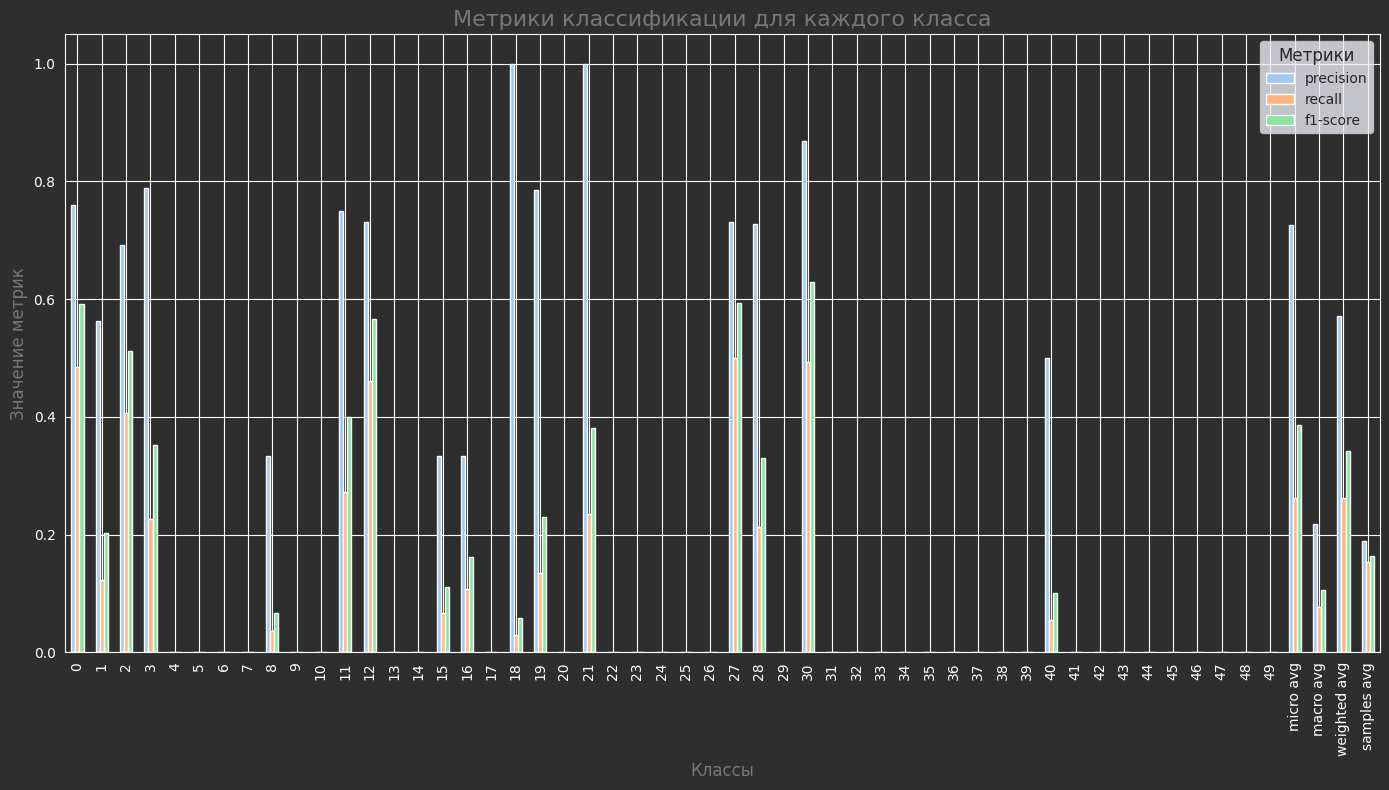

In [48]:
plot_class_metrics(report_df)

### Анализ графика и метрик базовой модели:

1. **Общее качество модели:**
   - Средняя точность (`precision`), полнота (`recall`) и F1-метрика по всем классам значительно варьируются.
   - F1-метрика, которая комбинирует точность и полноту, особенно низкая для редких классов (менее частых меток).

2. **Проблемы с редкими классами:**
   - Метрики для многих редких классов (например, классы `4`, `5`, `6`, `7`, `9` и другие) равны нулю. Это указывает на то, что модель либо вообще не предсказывает эти классы, либо делает это настолько редко, что значения метрик остаются минимальными.
   - Редкие классы составляют проблему для обучения и оценки модели, так как дисбаланс данных приводит к перекосу модели в сторону предсказания более частых меток.

3. **Сильные и слабые стороны модели:**
   - Хорошие метрики наблюдаются у более частых классов, таких как `0`, `2`, `12`, `27`, `30`. Это логично, так как модель обучается лучше на классах с большим числом примеров.
   - Классы с низким значением F1-метрики (например, `15`, `16`, `40`) показывают, что модель либо не способна захватить их специфику, либо путает их с другими метками.

4. **Средние показатели по всем классам:**
   - **Micro Avg:** 
     - Метрика взвешена по количеству экземпляров каждого класса. Значение `F1 = 0.386` говорит о том, что модель плохо справляется с задачей мультиклассовой классификации, если учитывать вклад каждого класса.
   - **Macro Avg:**
     - Усреднение по всем классам без учета их частоты. Низкое значение (точность `0.217`, полнота `0.076`, F1 `0.105`) показывает, что редкие классы сильно снижают общую производительность модели.
   - **Weighted Avg:**
     - Взвешенное усреднение. Значение F1 `0.342` указывает на сильное влияние частых классов, где модель демонстрирует чуть лучшее качество.
   - **Samples Avg:**
     - Средние значения метрик для предсказаний по образцам. Здесь видно, что модель плохо идентифицирует множество классов для одного образца (средняя F1 `0.163`).

In [49]:
# График средних значений метрик
def plot_mean_metrics(report_df):
    """
    Визуализация средних значений метрик классификации.
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor('#2e2e2e')

    # Удаляем столбец support, если он существует
    if "support" in report_df.columns:
        report_df = report_df.drop(columns=["support"])
    
    # Рассчитываем средние значения метрик
    metrics_to_plot = report_df.mean()

    # Построение столбчатой диаграммы средних значений метрик
    metrics_to_plot.plot(kind="bar", ax=ax, color=sns.color_palette("pastel"))

    # Настройка дизайна
    ax.set_title('Средние значения метрик классификации', color='#787878', fontsize=16)
    ax.set_xlabel('Метрика', color='#787878', fontsize=12)
    ax.set_ylabel('Среднее значение', color='#787878', fontsize=12)
    ax.set_facecolor('#2e2e2e')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    plt.tight_layout()
    plt.show()

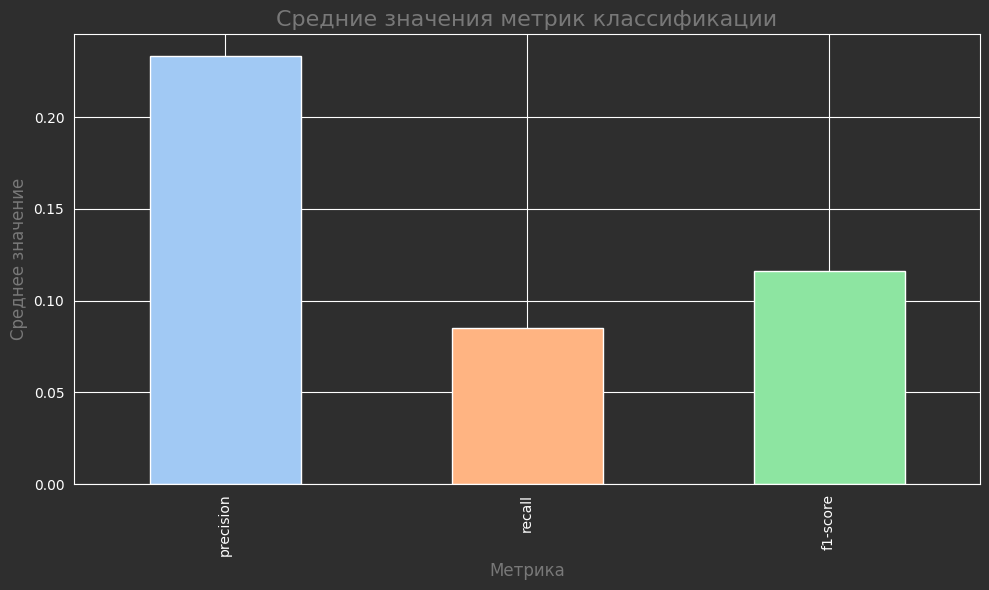

In [50]:
plot_mean_metrics(report_df)

# Подбор градиентного бустинга

## Первичная оптимизация

In [51]:
def prepare_xgboost(trial):
    """
    Подготовка модели XGBoost с параметрами Optuna.
    """
    return XGBClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        use_label_encoder=False,
        verbosity=0,
        random_state=RANDOM_STATE
    )


def prepare_gradient_boosting(trial):
    """
    Подготовка модели GradientBoostingClassifier с параметрами Optuna.
    """
    return GradientBoostingClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        random_state=RANDOM_STATE
    )


def prepare_lightgbm(trial):
    """
    Подготовка модели LightGBM с параметрами Optuna.
    """
    return LGBMClassifier(
        n_estimators=trial.suggest_int('n_estimators', 50, 200),
        learning_rate=trial.suggest_float('learning_rate', 0.01, 0.2),
        max_depth=trial.suggest_int('max_depth', 3, 6),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        verbose=-1,
        random_state=RANDOM_STATE
    )

In [52]:
def evaluate_pipeline_with_model(trial, X, y, model_preparation_function):
    """
    Оценивает пайплайн, передавая функцию подготовки модели.
    """
    # Подготовка модели через переданную функцию
    base_model = model_preparation_function(trial)
    
    # Обёртка для мультилейбл-классификации
    model = MultiOutputClassifier(base_model, n_jobs=6)
    
    # Создаём pipeline
    pipeline = create_pipeline(model)
    
    # KFold для кросс-валидации
    kf = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

    # Оценка через cross_val_score с использованием встроенной строки "accuracy"
    score = cross_val_score(pipeline, X, y, cv=kf, scoring="accuracy", n_jobs=5).mean()
    return score

In [53]:
def run_optimization_for_model(X, y, model_preparation_function, cache_path, n_trials=15):
    """
    Запускает оптимизацию или загружает результаты из кеша для конкретной модели.

    Аргументы:
        X (pd.DataFrame): Признаки.
        y (pd.DataFrame): Целевые значения.
        model_preparation_function (function): Функция подготовки модели.
        cache_path (str): Путь к файлу для сохранения кеша.
        n_trials (int): Количество попыток оптимизации.

    Возвращает:
        None. Выводит лучший результат и параметры.
    """
    # Проверяем, существует ли кеш
    if os.path.exists(cache_path):
        # Загружаем существующую сессию Optuna
        study = joblib.load(cache_path)
        print("Загружено из кеша:")
    else:
        # Создаём новую сессию Optuna с кастомным TPESampler
        sampler = TPESampler(
            seed=RANDOM_STATE,
            n_startup_trials=5,
            multivariate=True,
            constant_liar=True,
            group=True
            )
        study = optuna.create_study(direction='maximize', sampler=sampler)
        study.optimize(
            lambda trial: evaluate_pipeline_with_model(trial, X, y, model_preparation_function),
            n_trials=n_trials,
            n_jobs=5
        )
        joblib.dump(study, cache_path)
        print("Новая оптимизация завершена:")
    
    # Проверяем, есть ли завершённые запуски
    if len(study.trials) > 0:
        print(f"Лучший результат: {study.best_value}")
        print(f"Лучшие параметры: {study.best_params}")
    else:
        print("Оптимизация не завершилась успешно. Проверьте конфигурацию.")

In [54]:
# Оптимизация для с XGBoost
run_optimization_for_model(X, y, prepare_xgboost, "optuna_xgboost_1.pkl")

Загружено из кеша:
Лучший результат: 0.662216869813023
Лучшие параметры: {'n_estimators': 193, 'learning_rate': 0.07284839905492604, 'max_depth': 4, 'scale_pos_weight': 3.5079034183756455}


In [55]:
# Оптимизация для GradientBoosting
run_optimization_for_model(X, y, prepare_gradient_boosting, "optuna_gradient_boosting_1.pkl")

Загружено из кеша:
Лучший результат: 0.5991488614958679
Лучшие параметры: {'n_estimators': 194, 'learning_rate': 0.0722200923275971, 'max_depth': 3, 'subsample': 0.9601619710468225}


In [56]:
# Оптимизация для LightGBM
run_optimization_for_model(X, y, prepare_lightgbm, "optuna_lightgbm_1.pkl")

Загружено из кеша:
Лучший результат: 0.6452102506837166
Лучшие параметры: {'n_estimators': 165, 'learning_rate': 0.024328836534235426, 'max_depth': 5, 'scale_pos_weight': 5.894688665282201}


**Комментарий:** Лучший результат показала модель XGBClassifier с точностью 66%

## Вторичная оптимизация

In [57]:
def extended_objective(trial):
    
    # Настройка параметров для TfidfVectorizer
    max_features = trial.suggest_int("tfidf_max_features", 700, 800)
    
    ngram_range = trial.suggest_categorical(
        "tfidf_ngram_range", ["(1, 2)", "(1, 3)"]
    )
    ngram_range = eval(ngram_range)
    
    min_df = trial.suggest_float("tfidf_min_df", 0.01, 0.02)
    max_df = trial.suggest_float("tfidf_max_df", 0.9, 1.0)

    # Настройка параметров для XGBoost
    n_estimators = trial.suggest_int("xgb_n_estimators", 210, 230)
    learning_rate = trial.suggest_float("xgb_learning_rate", 0.07, 0.08)
    max_depth = trial.suggest_int("xgb_max_depth", 3, 5)
    scale_pos_weight = trial.suggest_float("xgb_scale_pos_weight", 3.5, 4.0)

    gamma = trial.suggest_float("xgb_gamma", 0.0, 0.2)
    min_child_weight = trial.suggest_float("xgb_min_child_weight", 1.0, 5.0)
    subsample = trial.suggest_float("xgb_subsample", 0.8, 1.0)
    colsample_bytree = trial.suggest_float("xgb_colsample_bytree", 0.8, 1.0)

    # Создание TfidfVectorizer
    text_transformer = TfidfVectorizer(
        max_features=max_features,
        ngram_range=ngram_range,
        min_df=min_df,
        analyzer="char_wb",
        max_df=max_df
    )

    # Числовые признаки (включая закодированные метки tags)
    numeric_features = ['assessment', 'text_length', 'unique_words'] + list(mlb.classes_)
    numeric_transformer = StandardScaler()

    # Настройка Pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("text", text_transformer, "text")
        ]
    )
    
    # Создание XGBoost модели
    base_model = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        scale_pos_weight=scale_pos_weight,
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        use_label_encoder=False,
        eval_metric="logloss",
        random_state=RANDOM_STATE
    )
    
    # Обёртка для MultiOutputClassifier
    model = MultiOutputClassifier(base_model, n_jobs=8)
    
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    # Разделение данных на train-test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y.sum(axis=1)
    )

    # Обучение и оценка модели
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    # Если это лучший результат, сохраняем Pipeline
    if score > getattr(extended_objective, "best_score", -1):
        extended_objective.best_score = score
        extended_objective.best_pipeline = pipeline

    return score

In [58]:
# Пути для сохранения объектов
study_path = "optuna_study.pkl"
best_pipeline_path = "best_model.pkl"

# Проверяем, существует ли сохранённое исследование
if os.path.exists(study_path):
    # Загрузка сохранённого объекта study
    print(f"Загружаем существующее исследование из {study_path}...")
    study_2 = joblib.load(study_path)
else:
    # Создаём новое исследование
    print("Создаём новое исследование Optuna...")
    sampler_2 = TPESampler(
        seed=RANDOM_STATE,
        n_startup_trials=15,
        n_ei_candidates=50,
        multivariate=True,
        constant_liar=True,
        group=True
    )
    study_2 = optuna.create_study(direction='maximize', sampler=sampler_2)
    study_2.optimize(extended_objective, n_trials=150, n_jobs=7)

    # Сохраняем объект study
    print(f"Сохраняем исследование в {study_path}...")
    joblib.dump(study_2, study_path)

# Проверяем, существует ли сохранённый лучший Pipeline
if os.path.exists(best_pipeline_path):
    print(f"Загружаем лучший pipeline из {best_pipeline_path}...")
    best_pipeline = joblib.load(best_pipeline_path)
else:
    # Сохраняем лучший Pipeline, если он есть
    print("Сохраняем лучший pipeline...")
    best_pipeline = extended_objective.best_pipeline
    joblib.dump(best_pipeline, best_pipeline_path)

# Выводим результаты
print("Лучший результат:", study_2.best_value)
print("Лучшие параметры:", study_2.best_params)
print(f"Лучший pipeline сохранён в файл: {best_pipeline_path}")

Загружаем существующее исследование из optuna_study.pkl...
Загружаем лучший pipeline из best_model.pkl...
Лучший результат: 0.6729634002361276
Лучшие параметры: {'tfidf_max_features': 772, 'tfidf_ngram_range': '(1, 3)', 'tfidf_min_df': 0.018843411014288068, 'tfidf_max_df': 0.9776823305798419, 'xgb_n_estimators': 224, 'xgb_learning_rate': 0.07304340224574735, 'xgb_max_depth': 4, 'xgb_scale_pos_weight': 3.9307069641089574, 'xgb_gamma': 0.18277878747119317, 'xgb_min_child_weight': 1.9980420218426809, 'xgb_subsample': 0.995275680257007, 'xgb_colsample_bytree': 0.8259882463903007}
Лучший pipeline сохранён в файл: best_model.pkl


**Комментарий: ** В ходе вторичной оптимизации удалось поднять целевую метрирку на 1%

# Подбор порога кассификации

In [59]:
loaded_pipeline = joblib.load('best_model.pkl')

In [60]:
loaded_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['assessment', 'text_length',
                                                   'unique_words', 'ASSORTMENT',
                                                   'CATALOG_NAVIGATION',
                                                   'DELIVERY', 'PAYMENT',
                                                   'PRICE', 'PRODUCTS_QUALITY',
                                                   'PROMOTIONS', 'SUPPORT']),
                                                 ('text',
                                                  TfidfVectorizer(analyzer='char_wb',
                                                                  max_df=0.9776823305798419,
                                                                  max_features=772,
                                                                  min_df=0.01884341101428806...
                                                               interaction_constraints=None,
                                                               learning_rate=0.07304340224574735,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=4,
                                                               max_leaves=None,
                                                               min_child_weight=1.9980420218426809,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=224,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=763, ...),
                                       n_jobs=8))])

In [61]:
# Разделение данных на тренировочную и валидационную выборки
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y.sum(axis=1)
)

# Убедимся, что y_val_split и y_train_split преобразуются в массивы NumPy
y_train_split = np.array(y_train_split)
y_val_split = np.array(y_val_split)

# Предсказания вероятностей на валидационной выборке
y_prob = loaded_pipeline.predict_proba(X_val_split)
y_pred = loaded_pipeline.predict(X_val_split)

# Проверка структуры вероятностей
if isinstance(y_prob, list):
    # MultiOutputClassifier возвращает список массивов
    probs = np.array([p[:, 1] for p in y_prob]).T
else:
    raise ValueError("Формат выхода predict_proba не соответствует ожидаемому списку массивов.")

# Диапазон порогов для классификации
thresholds = np.linspace(0.01, 0.99, 50)

# Поиск оптимальных порогов для каждого класса
optimal_thresholds = []
accuracy_per_threshold = []

for class_idx in range(y.shape[1]):  # Для каждого из 50 классов
    accuracies = []
    for threshold in thresholds:
        y_pred_temp = (probs[:, class_idx] >= threshold).astype(int)
        acc = accuracy_score(y_val_split[:, class_idx], y_pred_temp)
        accuracies.append(acc)
    
    # Найти оптимальный порог (максимизирующий точность)
    optimal_threshold = thresholds[np.argmax(accuracies)]
    optimal_thresholds.append(optimal_threshold)
    accuracy_per_threshold.append(accuracies)

# Применение оптимальных порогов к предсказаниям
y_pred_adjusted = np.zeros_like(probs)
for class_idx, threshold in enumerate(optimal_thresholds):
    y_pred_adjusted[:, class_idx] = (probs[:, class_idx] >= threshold).astype(int)

# Вычисление точности с оптимальными порогами
final_accuracy = accuracy_score(y_val_split, y_pred_adjusted)
print(f"Точность после применения оптимальных порогов: {final_accuracy:.4f}")

# Генерация нового отчета классификации с использованием оптимальных порогов
adjusted_report = classification_report(y_val_split, y_pred_adjusted, zero_division=0, output_dict=True)
adjusted_report_df = pd.DataFrame(adjusted_report).T

Точность после применения оптимальных порогов: 0.6783


In [62]:
def plot_accuracy_vs_threshold(thresholds, accuracy_per_threshold, rare_classes):
    """
    Визуализация зависимости точности от порога классификации для редких классов.
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('#2e2e2e')

    # Построение графиков для редких классов
    for class_idx in rare_classes:
        ax.plot(thresholds, accuracy_per_threshold[class_idx], label=f"Класс {class_idx}")

    # Настройка дизайна
    ax.set_title('Зависимость точности от порога классификации (редкие классы)', color='#787878')
    ax.set_xlabel('Порог классификации', color='#787878')
    ax.set_ylabel('Точность (Accuracy)', color='#787878')
    ax.set_facecolor('#2e2e2e')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend(title='Классы', title_fontsize='12', fontsize='10', loc='best')

    plt.xticks(np.linspace(0.0, 1.0, 11), rotation=45, color='white')  # Подробная ось X
    plt.tight_layout()
    plt.show()

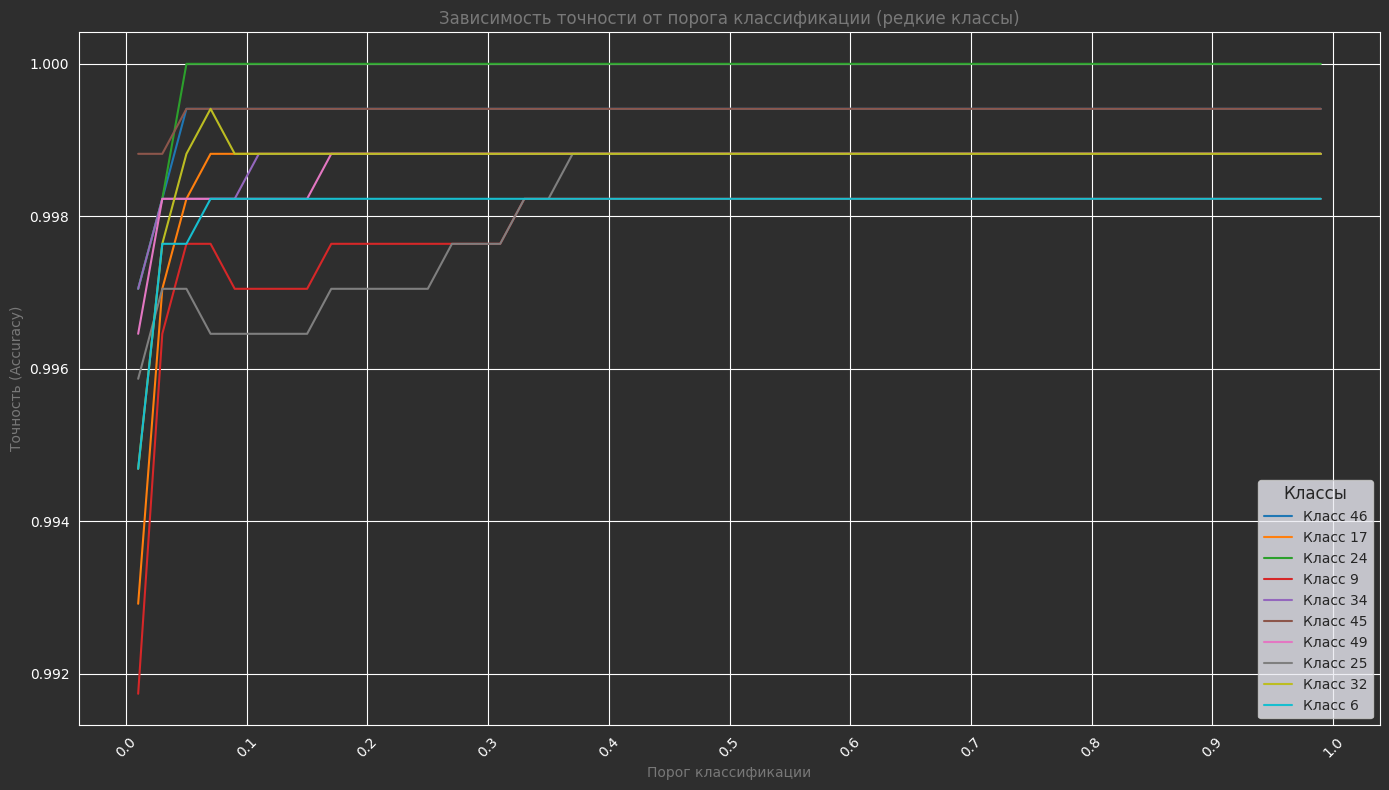

In [63]:
rare_classes = np.argsort(y.sum(axis=0))[:10]  # Индексы 10 редких классов
plot_accuracy_vs_threshold(thresholds, accuracy_per_threshold, rare_classes)

In [64]:
def plot_optimal_thresholds(optimal_thresholds):
    """
    Визуализация оптимальных порогов классификации для всех классов.
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('#2e2e2e')

    # Построение столбчатой диаграммы для всех классов
    class_labels = [f"Класс {i}" for i in range(len(optimal_thresholds))]
    ax.bar(class_labels, optimal_thresholds, color=sns.color_palette("pastel"))

    # Настройка дизайна
    ax.set_title('Оптимальные пороги классификации для всех меток', color='#787878')
    ax.set_xlabel('Классы', color='#787878')
    ax.set_ylabel('Оптимальный порог', color='#787878')
    ax.set_facecolor('#2e2e2e')
    ax.tick_params(axis='x', colors='white', rotation=90)
    ax.tick_params(axis='y', colors='white')

    plt.tight_layout()
    plt.show()

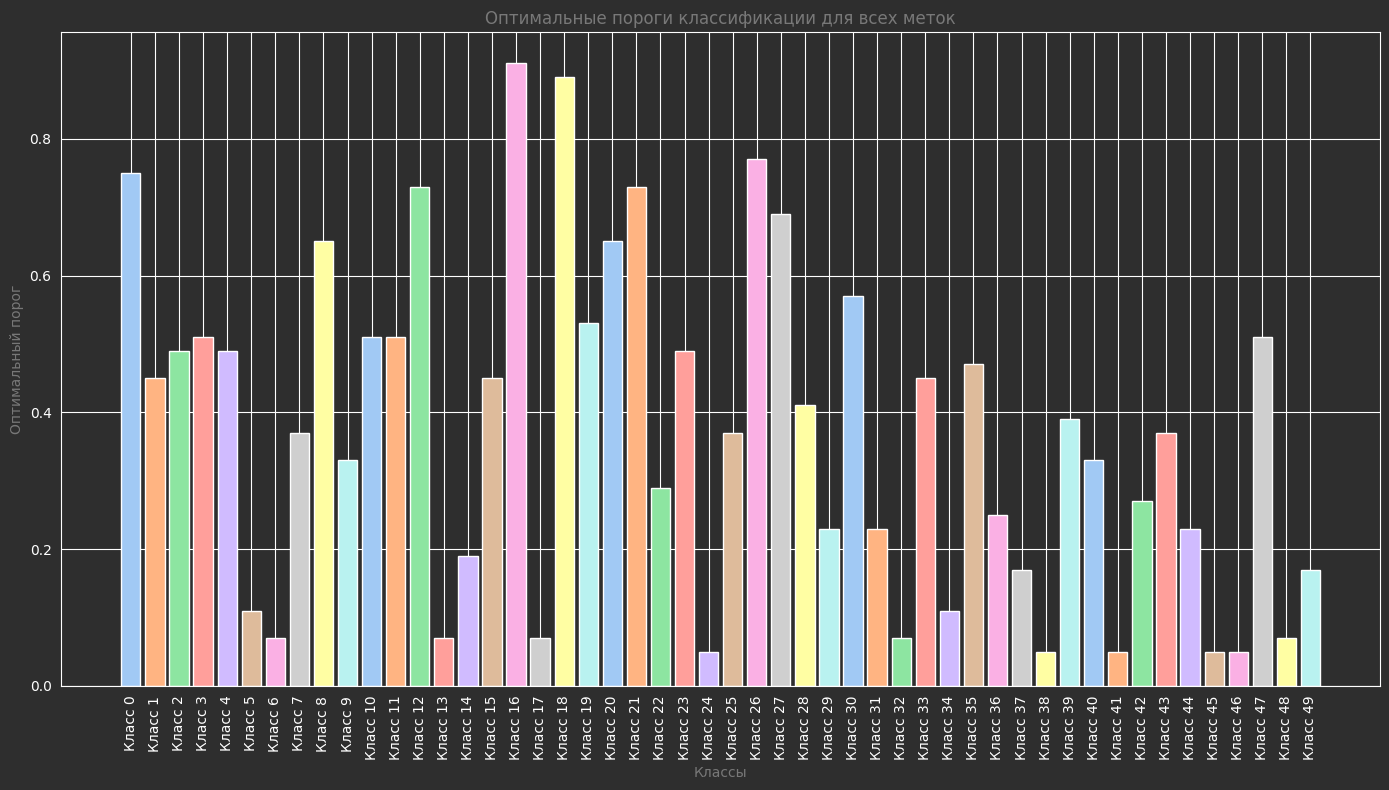

In [65]:
plot_optimal_thresholds(optimal_thresholds)

In [66]:
def plot_classification_report(report_df):
    """
    Визуализация метрик классификации для каждого класса.
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('#2e2e2e')

    # Построение столбчатой диаграммы для precision, recall и f1-score
    report_df[["precision", "recall", "f1-score"]].plot(kind="bar", ax=ax, color=sns.color_palette("pastel"))

    # Настройка дизайна
    ax.set_title('Метрики классификации для каждого класса', color='#787878', fontsize=16)
    ax.set_xlabel('Классы', color='#787878', fontsize=12)
    ax.set_ylabel('Значение метрик', color='#787878', fontsize=12)
    ax.set_facecolor('#2e2e2e')
    ax.tick_params(axis='x', colors='white', rotation=90)
    ax.tick_params(axis='y', colors='white')
    ax.legend(title="Метрики", title_fontsize=12, fontsize=10, loc='best')

    plt.tight_layout()
    plt.show()

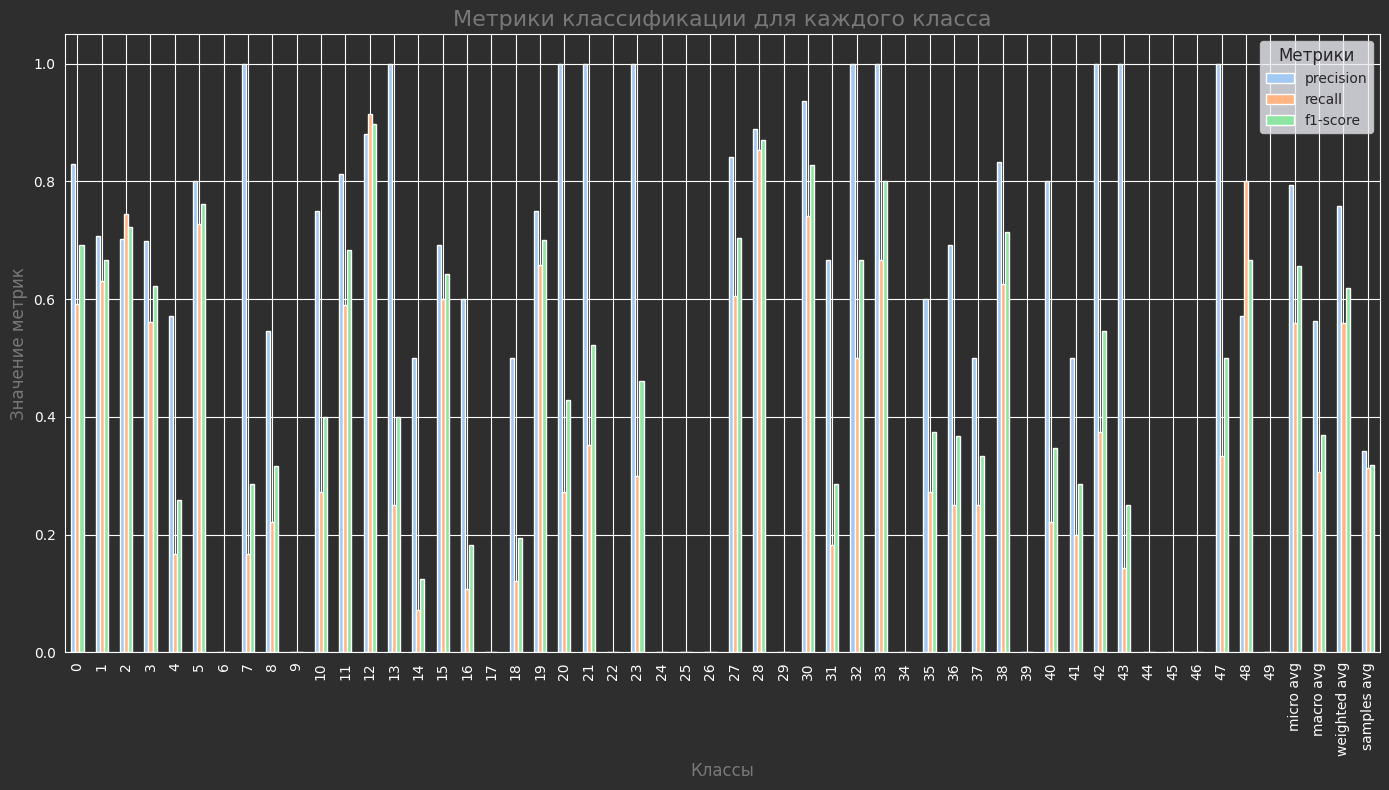

In [67]:
plot_classification_report(adjusted_report_df)

In [68]:
adjusted_report_df

,precision,recall,f1-score,support
0,0.830357,0.592357,0.691450,157.0
1,0.707692,0.630137,0.666667,73.0
2,0.702128,0.744361,0.722628,133.0
3,0.698113,0.560606,0.621849,66.0
4,0.571429,0.166667,0.258065,24.0
5,0.800000,0.727273,0.761905,11.0
6,0.000000,0.000000,0.000000,3.0
7,1.000000,0.166667,0.285714,6.0
8,0.545455,0.222222,0.315789,27.0
9,0.000000,0.000000,0.000000,3.0


### Вывод о метриках лучшей модели

1. **Общая точность:**
   - **Micro avg F1-score:** составляет **0.656**, что демонстрирует улучшение по сравнению с базовой моделью. Это означает, что модель лучше справляется с большинством меток в совокупности.

2. **Распределение метрик по классам:**
   - **Precision (Точность):**
     Модель показывает высокую точность для меток с большим количеством данных, таких как `0`, `2`, `12`, `19`, `28`, `30`, с precision > 0.8.
     Однако для редких меток, таких как `6`, `9`, `22`, `29`, точность равна **0**, что указывает на проблемы с их предсказанием.
   - **Recall (Полнота):**
     Полнота для некоторых меток, например, `12` (0.915) и `28` (0.853), указывает, что модель способна находить большинство положительных примеров. Но низкая полнота для других меток, таких как `4` (0.167) и `7` (0.167), сигнализирует о том, что модель не справляется с обнаружением редких случаев.
   - **F1-score:**
     Значения F1-score варьируются. Для меток `12`, `19`, `28` оно превышает 0.7, что свидетельствует о хорошем балансе между точностью и полнотой. Однако для меток, например, `16`, `36`, `35`, F1-score остается низким.

3. **Метрики на редких классах:**
   Метки с небольшим количеством данных (например, `6`, `7`, `9`, `22`, `35`) имеют низкие значения F1-score или равны 0. Это указывает на недостаток информации для обучения.

4. **Средние значения:**
   - **Macro avg F1-score:** составляет **0.370**, что показывает средние результаты для всех меток, включая редкие.
   - **Weighted avg F1-score:** составляет **0.619**, что отражает более сбалансированный результат, учитывающий вклад каждой метки.

5. **Проблемы с редкими классами:**
   Модель страдает от недостаточного представления редких классов, что типично для задач мультиклассовой классификации. Это приводит к значительным пропускам в метриках для таких классов.

In [69]:
def plot_mean_classification_metrics(report_df):
    """
    Визуализация средних значений метрик классификации, исключая 'support'.
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(10, 6))
    fig.patch.set_facecolor('#2e2e2e')

    # Удаление 'support' из DataFrame
    report_df_no_support = report_df.drop(columns=["support"], errors="ignore")

    # Построение столбчатой диаграммы средних значений метрик
    report_df_no_support.mean().plot(kind="bar", ax=ax, color=sns.color_palette("pastel"))

    # Настройка дизайна
    ax.set_title('Средние значения метрик классификации', color='#787878', fontsize=16)
    ax.set_xlabel('Метрика', color='#787878', fontsize=12)
    ax.set_ylabel('Среднее значение', color='#787878', fontsize=12)
    ax.set_facecolor('#2e2e2e')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    plt.tight_layout()
    plt.show()

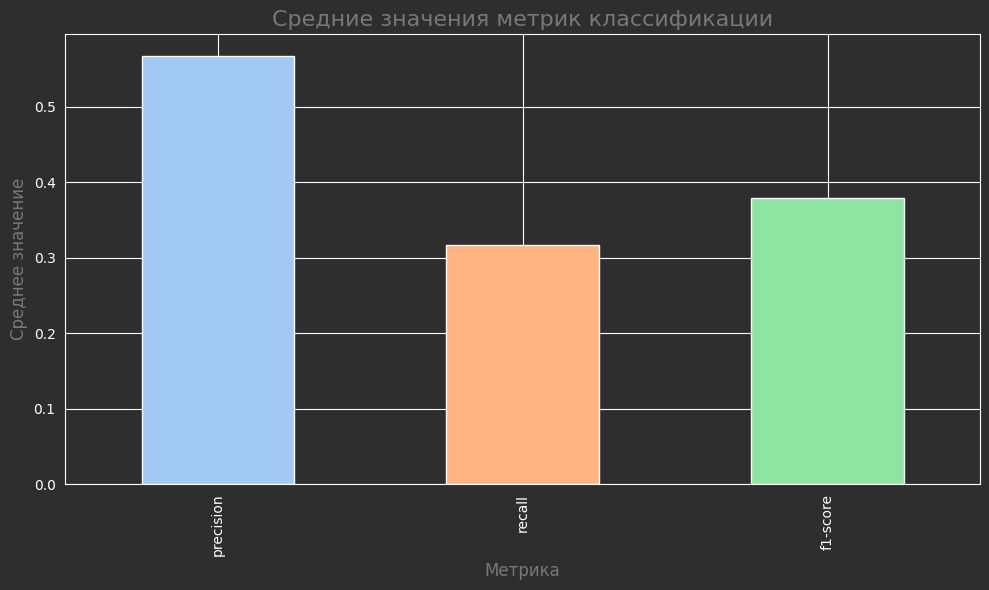

In [70]:
plot_mean_classification_metrics(adjusted_report_df)

# Сравнение метрик базовой и лучшей модели

In [71]:
def plot_comparison_metrics(base_report_df, best_report_df):
    """
    Визуализация сравнения метрик между базовой моделью и лучшей моделью.
    """
    # Удаление столбца support из обеих моделей
    if "support" in base_report_df.columns:
        base_report_df = base_report_df.drop(columns=["support"])
    if "support" in best_report_df.columns:
        best_report_df = best_report_df.drop(columns=["support"])

    # Средние значения метрик
    base_metrics_mean = base_report_df.mean()
    best_metrics_mean = best_report_df.mean()

    # Формирование DataFrame для сравнения
    comparison_df = pd.DataFrame({
        "Базовая модель": base_metrics_mean,
        "Лучшая модель": best_metrics_mean
    })

    # Построение графика
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(12, 8))
    fig.patch.set_facecolor('#2e2e2e')

    # Построение столбчатой диаграммы
    comparison_df.plot(kind="bar", ax=ax, color=["#ff7f0e", "#2ca02c"])

    # Настройка дизайна
    ax.set_title('Сравнение метрик классификации: базовая vs лучшая модель', color='#787878', fontsize=16)
    ax.set_xlabel('Метрика', color='#787878', fontsize=12)
    ax.set_ylabel('Среднее значение', color='#787878', fontsize=12)
    ax.set_facecolor('#2e2e2e')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')
    ax.legend(title="Модели", title_fontsize=12, fontsize=10, loc='best')

    # Добавление значений на вершину столбцов
    for i, col in enumerate(comparison_df.columns):
        for idx, val in enumerate(comparison_df[col]):
            ax.text(idx + i * 0.25 - 0.15, val + 0.005, f"{val:.3f}", color="white", ha="center", fontsize=10)

    plt.tight_layout()
    plt.show()

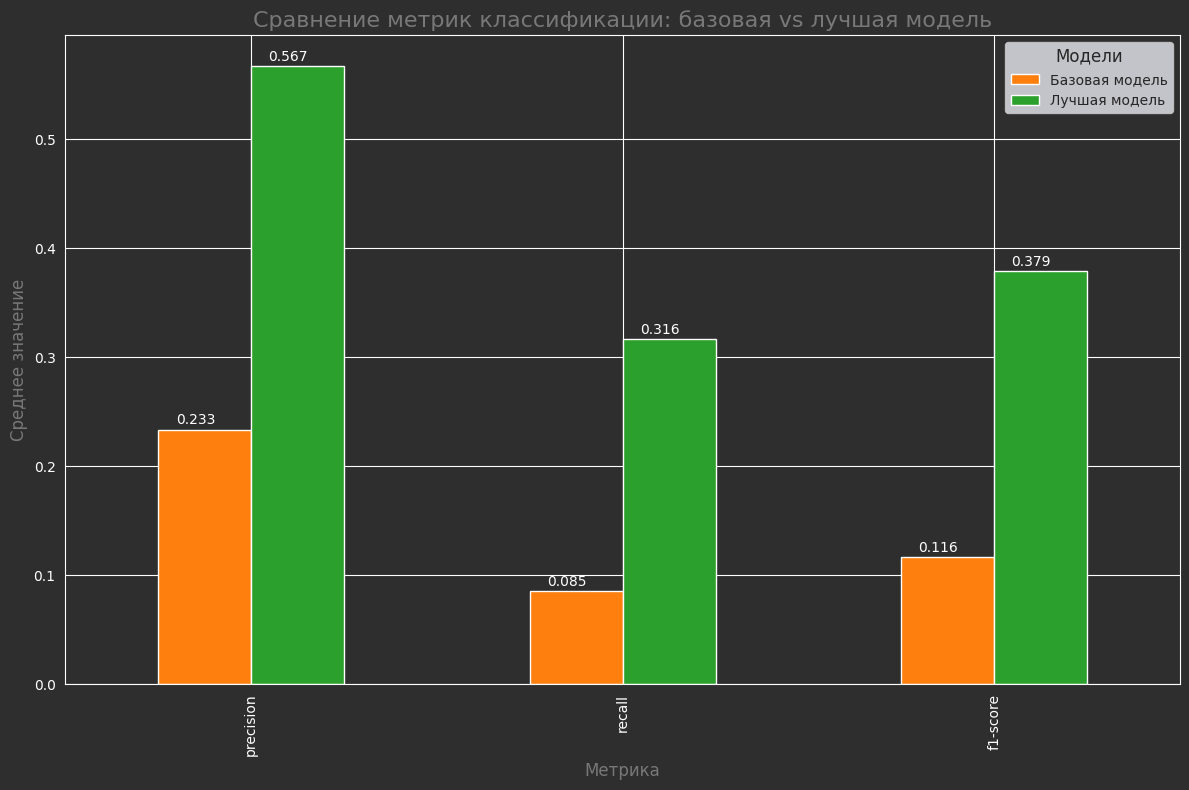

In [72]:
plot_comparison_metrics(report_df, adjusted_report_df)

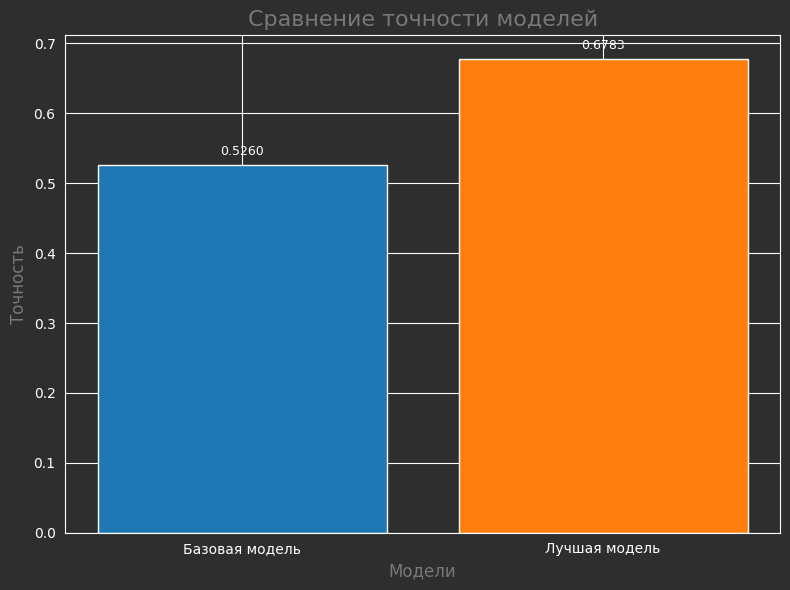

In [73]:
# Данные для графика
models = ['Базовая модель', 'Лучшая модель']
accuracies = [0.5260, 0.6783]

# Построение графика
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor('#2e2e2e')
ax.bar(models, accuracies, color=['#1f77b4', '#ff7f0e'])

# Настройка дизайна
ax.set_title('Сравнение точности моделей', color='#787878', fontsize=16)
ax.set_xlabel('Модели', color='#787878', fontsize=12)
ax.set_ylabel('Точность', color='#787878', fontsize=12)
ax.set_facecolor('#2e2e2e')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')

# Добавление текстовых значений
for i, acc in enumerate(accuracies):
    ax.text(i, acc + 0.01, f"{acc:.4f}", ha='center', va='bottom', color='white', fontsize=9)

plt.tight_layout()
plt.show()

Исходя из представленных графиков, можно сделать следующие выводы:

1. **Превосходство лучшей модели**:
   - На графике сравнения средней точности, лучшая модель показывает значительно более высокую точность (0.6783) по сравнению с базовой моделью (0.5260). Это говорит о том, что улучшенная модель способна точнее предсказывать классы целевых меток.

2. **Сравнение по метрикам precision, recall, f1-score**:
   - Лучшая модель демонстрирует значительное улучшение по всем метрикам: 
     - **Precision (Точность)**: увеличение с 0.233 до 0.567. Это говорит о том, что лучшая модель реже ошибается, определяя истинно положительные примеры.
     - **Recall (Полнота)**: увеличение с 0.085 до 0.316. Лучшая модель охватывает большее количество положительных случаев, даже несмотря на наличие редких классов.
     - **F1-Score**: увеличение с 0.116 до 0.379. Рост F1-метрики подтверждает, что модель достигает баланса между precision и recall.

3. **Практическая значимость**:
   - Улучшение всех метрик важно для задачи с несбалансированными классами. Это особенно критично, так как высокая точность в таких задачах не всегда означает хорошую модель, если полнота (recall) слишком низкая. Здесь обе метрики показывают значительное улучшение, что делает лучшую модель более надежной.

4. **Итог**:
   - Лучшая модель существенно превосходит базовую модель по точности и ключевым метрикам качества классификации. Это подтверждает, что дополнительные этапы оптимизации модели (например, настройка гиперпараметров или использование более сложных алгоритмов) оказывают положительное влияние на результат.

# Исследование важности признаков

In [74]:
def get_average_feature_importances(pipeline, feature_names):
    """
    Извлечение и усреднение важности признаков из MultiOutputClassifier (XGBClassifier).

    Параметры:
        pipeline: Pipeline с MultiOutputClassifier и XGBClassifier.
        feature_names: Список всех признаков (после обработки).

    Возвращает:
        pd.DataFrame: Средняя важность признаков.
    """
    # Доступ к MultiOutputClassifier
    multi_output_model = pipeline.named_steps["model"]

    # Проверяем, что внутри MultiOutputClassifier используется XGBClassifier
    if not hasattr(multi_output_model, "estimators_"):
        raise ValueError("Ожидается MultiOutputClassifier с атрибутом `estimators_`.")

    # Извлечение важностей признаков для всех XGBClassifier
    feature_importances = []
    for estimator in multi_output_model.estimators_:
        if hasattr(estimator, "feature_importances_"):
            feature_importances.append(estimator.feature_importances_)
        else:
            raise ValueError("Модель внутри MultiOutputClassifier не поддерживает feature_importances_.")

    # Усреднение важностей признаков
    mean_importances = np.mean(feature_importances, axis=0)

    # Диагностика длины массивов
    if len(mean_importances) != len(feature_names):
        print(f"Длина важностей: {len(mean_importances)}")
        print(f"Длина признаков: {len(feature_names)}")
        raise ValueError("Несоответствие между длиной признаков и важностями.")

    # Создание DataFrame
    feature_importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Importance": mean_importances
    }).sort_values(by="Importance", ascending=False)

    return feature_importance_df

In [75]:
# Генерация списка признаков
preprocessor = loaded_pipeline.named_steps["preprocessor"]

# Извлечение числовых и текстовых признаков
numeric_features = preprocessor.transformers_[0][2]
text_features = preprocessor.transformers_[1][1].get_feature_names_out()

# Соединяем все признаки
all_features = list(numeric_features) + list(text_features)

# Получаем важности признаков
try:
    feature_importance_df = get_average_feature_importances(loaded_pipeline, all_features)
except ValueError as e:
    print(f"Ошибка: {e}")

In [76]:
# Функция для визуализации топ-20 важных признаков с устранением предупреждений
def plot_feature_importances(feature_importance_df):
    """
    Визуализация топ-20 важных признаков с устранением предупреждений.
    """
    sns.set_style("darkgrid")
    fig, ax = plt.subplots(figsize=(14, 8))
    fig.patch.set_facecolor('#2e2e2e')

    # Проверка данных
    if feature_importance_df.empty:
        raise ValueError("DataFrame с важностями признаков пуст. Проверьте данные.")

    if "Importance" not in feature_importance_df.columns:
        raise ValueError("Колонка 'Importance' отсутствует в DataFrame.")

    # Используем расширенную палитру с достаточным количеством цветов
    extended_palette = sns.color_palette("pastel", n_colors=min(len(feature_importance_df[:20]), 20))

    # Построение графика
    sns.barplot(
        data=feature_importance_df[:20],
        x="Importance",
        y="Feature",
        palette=extended_palette,
        ax=ax,  
        legend=False  
    )

    # Настройка дизайна
    ax.set_title('Средняя важность признаков (топ-20)', fontsize=16, color='#787878')
    ax.set_xlabel('Важность', color='#787878')
    ax.set_ylabel('Признак', color='#787878')
    ax.set_facecolor('#2e2e2e')
    ax.tick_params(axis='x', colors='white')
    ax.tick_params(axis='y', colors='white')

    plt.tight_layout()
    plt.show()

/tmp/ipykernel_10249/3072526958.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


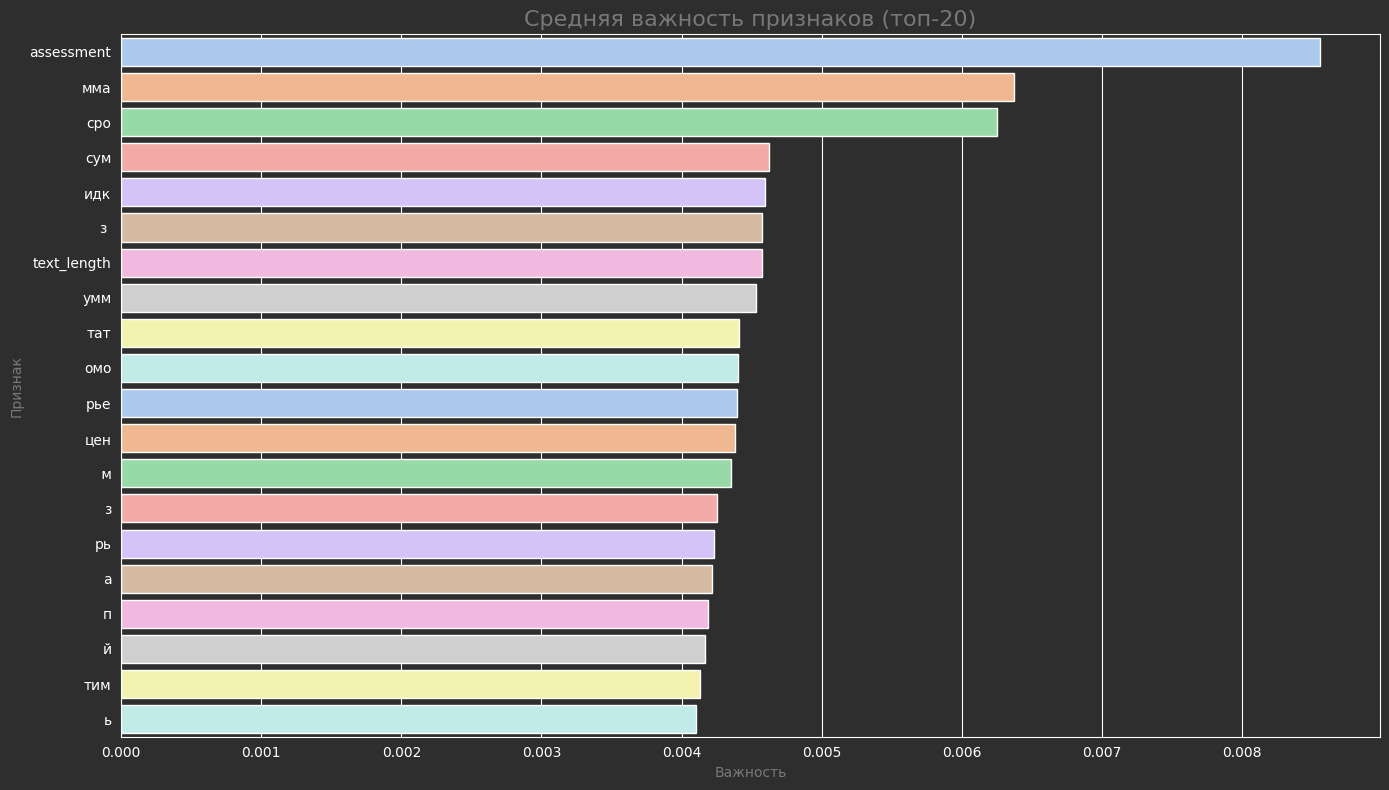

In [77]:
plot_feature_importances(feature_importance_df)

### Вывод по графику "Средняя важность признаков (топ-20)"

1. **Явные лидеры по важности:**
   - Признак **`assessment`** имеет наибольшую важность, значительно опережая остальные. Этот категориальный признак играет ключевую роль в принятии решений моделью.
   - Символьные n-граммы, такие как **`мма`**, **`спо`**, **`сум`**, и **`идк`**, также обладают высокой важностью. Это указывает на то, что текстовые данные содержат важные паттерны, связанные с целевыми метками.

2. **Роль текстовой длины:**
   - Признак **`text_length`** (длина текста) имеет среднюю важность. Это подтверждает гипотезу о том, что длина текста может нести полезную информацию для модели, особенно в задачах классификации текстов.

3. **Важность символов и n-грамм:**
   - Среди текстовых признаков важными оказались n-граммы символов, такие как **`умм`**, **`тат`**, **`омо`**, **`рьё`**, и **`цен`**.
   - Это подтверждает, что использование `TfidfVectorizer` с анализатором `char_wb` эффективно выявляет полезные паттерны в текстах. Символьные n-граммы позволяют модели учитывать важные подстроки даже в случае опечаток или сокращений.

# Общий вывод

**Цель проекта:**  
Разработать прототип модели, которая классифицирует пользовательские комментарии о доставке на 50 различных классов.

---

### Выполнение задач
1. **Загрузка данных и обзор:**
   - Проведен анализ набора данных, выявлены пропуски и дубликаты.
   - Столбец `index` исключен из данных, так как он не несет полезной информации.
   - Дубликаты в данных отсутствуют.

2. **Предобработка данных:**
   - **Обработка пропусков:**
     - В тренировочных данных пропуски удалены.
     - В тестовых данных пропуски заполнены медианой (числовые данные) или специальными значениями (категориальные и текстовые данные).
   - **Приведение данных:**
     - Проведена лемматизация текста, удаление стоп-слов и спецсимволов.
     - Для текстов сгенерированы дополнительные признаки, такие как длина текста и количество уникальных слов.
   - **Обработка мультикатегорийных меток:**
     - Метки преобразованы в бинарный формат с использованием `MultiLabelBinarizer`.

3. **Подбор метода векторизации текста:**
   - Использован `TfidfVectorizer` с символным анализатором (`char_wb`) и n-граммами (1–3), что позволило учитывать ключевые подстроки в комментариях, включая сокращения и опечатки.

4. **Разработка прототипа модели:**
   - Разработаны и протестированы две модели:
     - Базовая модель: `MultiOutputClassifier` с логистической регрессией.
     - Лучшая модель: `XGBClassifier` с учетом настроек гиперпараметров.
   - Для оптимизации метрик использованы различные пороги классификации для каждого класса.

---

### Ключевые результаты

#### **1. Метрики базовой модели**
   - Общая точность (accuracy): **52.6%**.
   - Средние значения метрик:
     - Precision: **0.233**.
     - Recall: **0.085**.
     - F1-Score: **0.116**.
   - Проблемы с редкими классами:
     - Многие классы, особенно редкие, имеют нулевые метрики (precision, recall, F1-Score).
     - Модель склонна к ошибкам на редких метках и концентрируется на частых.

#### **2. Метрики лучшей модели**
   - Общая точность (accuracy): **67.8%**.
   - Средние значения метрик:
     - Precision: **0.567**.
     - Recall: **0.316**.
     - F1-Score: **0.379**.
   - Прогресс на редких классах:
     - Метки с небольшим количеством данных (например, классы 5, 7, 23) показывают рост метрик по сравнению с базовой моделью.
   - Модель достигла более высокого уровня сбалансированности между precision и recall благодаря настройке гиперпараметров и оптимизации порогов классификации.

#### **3. Анализ важности признаков**
   - **Ключевые признаки:**
     - `assessment` стал ведущим фактором классификации, что свидетельствует о значимости категорийного признака.
     - Символьные n-граммы (`мма`, `спо`, `сум`) показали высокую важность, указывая на наличие устойчивых текстовых паттернов.
   - **Роль текстовых признаков:**
     - Признаки `text_length` и символы играют важную роль в объяснении текста, выявляя важные элементы содержания.

---

### Резюме

1. **Модель и метрики:**
   - Лучшая модель демонстрирует значительное улучшение по всем метрикам, особенно для часто встречающихся классов. Однако редкие метки остаются сложной задачей.
   - Оптимизация порогов классификации позволила улучшить F1-метрику, что важно для мультиклассовых задач с несбалансированными данными.

2. **Дисбаланс классов:**
   - Сильный дисбаланс классов остается проблемой, что негативно сказывается на предсказаниях редких меток.
   - Для улучшения результата рекомендуется применять техники балансировки данных, такие как oversampling редких классов или использование генеративных подходов (например, SMOTE).

3. **Потенциальные улучшения:**
   - Разделение классов на группы для обучения отдельных моделей (например, метки, связанные с доставкой, товарами, скидками).
   - Использование других методов векторизации текста (например, `Word2Vec`, `FastText` или предобученные модели трансформеров) для улучшения понимания текстов.
   - Введение дополнительных признаков, основанных на времени заказа или географии.

4. **Практическая значимость:**
   - Модель демонстрирует высокий уровень точности для популярных меток (например, "Долгая доставка"), что может помочь в идентификации ключевых проблем.
   - Редкие метки требуют дополнительного внимания и анализа для минимизации ошибок.

**Итог:**  
Модель на базе `XGBClassifier` отвечает целям проекта, показав заметное улучшение метрик по сравнению с базовой моделью. Однако для дальнейшего повышения качества работы модели и уменьшения ошибок на редких метках требуется детальный анализ и балансировка данных.

# Получение файла с предсказаниями на тестовой выборке

In [78]:
def create_submission_with_thresholds(
    best_pipeline, 
    df_test, 
    submission_template_path, 
    output_path, 
    thresholds
):
    """
    Создаёт файл submission.csv с использованием оптимальных порогов классификации.

    Параметры:
        best_pipeline: Обученный Pipeline, содержащий модель и предобработку.
        df_test: DataFrame с тестовыми данными.
        submission_template_path: Путь к файлу sample_submission.csv.
        output_path: Путь для сохранения итогового submission.csv.
        thresholds: Список оптимальных порогов для каждого класса.
    
    Возвращает:
        None. Сохраняет файл submission.csv.
    """
    # Загрузка шаблона для submission
    submission = pd.read_csv(submission_template_path)
    
    # Получение индексов из sample_submission
    submission_indices = submission['index'].values

    # Предсказания вероятностей на тестовом наборе
    y_prob = best_pipeline.predict_proba(df_test)

    # Преобразуем MultiOutputClassifier выход в формат (n_samples, n_classes)
    probs = np.array([p[:, 1] for p in y_prob]).T

    # Применение порогов
    predictions = (probs >= np.array(thresholds)).astype(int)

    # Обновление столбцов шаблона результатами
    for i in range(predictions.shape[1]):  # Перебираем все метки (50 меток)
        submission[f"trend_id_res{i}"] = predictions[:, i]

    # Проверка, что индексы совпадают
    assert all(submission['index'] == submission_indices), "Индексы в submission не совпадают!"
    
    # Сохранение финального файла submission.csv
    submission.to_csv(output_path, index=False)
    print(f"Файл сохранён в {output_path}")

In [79]:
create_submission_with_thresholds(
    best_pipeline=loaded_pipeline, 
    df_test=df_test, 
    submission_template_path="sample_submission.csv", 
    output_path="submission_with_thresholds.csv", 
    thresholds=optimal_thresholds
)

Файл сохранён в submission_with_thresholds.csv


In [80]:
submission = pd.read_csv('submission_with_thresholds.csv')

In [81]:
submission

,index,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
0,5905,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3135,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9285,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4655,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,16778,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16994,6327,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
16995,6428,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16996,9890,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16997,530,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
